# Hurricane Model Analysis

## Imports, Functions, Paths

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
import sys
import cv2

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from os import path, listdir
from tqdm import tqdm

sys.path.append('..')
from utils.utils import *
from models.hurricane import HurricaneModel, HurricaneAddModel, HurricaneDOModel, HurricaneCatModel, HurricaneLoRAModel

root = ".."
sam_checkpoint = "../checkpoints/sam_vit_b_01ec64.pth"

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Inference

In [ ]:
'''
validate method taken from this repo: https://github.com/DIUx-xView/xView2_first_place

F1 Classes:
    F1 - Harmonic Mean
    F1_0 - No Damage
    F1_1 - Minor
    F1_2 - Major
    F1_3 - Destroyed
'''

def validate(net, data_loader, device):
    dices0 = []

    tp = np.zeros((4,))
    fp = np.zeros((4,))
    fn = np.zeros((4,))

    _thr = 0.3

    with torch.no_grad():
        for i, sample in enumerate(tqdm(data_loader)):
            msks = sample["msk"].numpy()
            lbl_msk = sample["lbl_msk"].numpy()
            pre_img = sample["pre_img"].to(device, non_blocking=True)
            post_img = sample["post_img"].to(device, non_blocking=True)
            msks = sample["msk"].numpy()
            out = net(pre_img, post_img)

            msk_pred = torch.sigmoid(out[:, 0, ...]).cpu().numpy() > 0.3
            msk_damage_pred = torch.sigmoid(out).cpu().numpy()[:, 1:, ...]
            
            for j in range(msks.shape[0]):
                dices0.append(dice(msks[j, 0], msk_pred[j] > _thr))

                targ = lbl_msk[j][msks[j, 0] > 0]
                pred = msk_damage_pred[j].argmax(axis=0)
                pred = pred * (msk_pred[j] > _thr)
                pred = pred[msks[j, 0] > 0]
                for c in range(4):
                    tp[c] += np.logical_and(pred == c, targ == c).sum()
                    fn[c] += np.logical_and(pred != c, targ == c).sum()
                    fp[c] += np.logical_and(pred == c, targ != c).sum()

    d0 = np.mean(dices0)

    f1_sc = np.zeros((4,))
    for c in range(4):
        f1_sc[c] = 2 * tp[c] / (2 * tp[c] + fp[c] + fn[c])

    f1 = 4 / np.sum(1.0 / (f1_sc + 1e-6))

    sc = 0.3 * d0 + 0.7 * f1
    """
    F1 Classes:
    F1 - Harmonic Mean
    F1_0 - No Damage
    F1_1 - Minor
    F1_2 - Major
    F1_3 - Destroyed
    """
    print("Val Score: {}, Dice: {}, F1: {}, F1_0: {}, F1_1: {}, F1_2: {}, F1_3: {}".format(sc, d0, f1, f1_sc[0], f1_sc[1], f1_sc[2], f1_sc[3]))
    return (sc, d0, f1, f1_sc[0], f1_sc[1], f1_sc[2], f1_sc[3])

In [ ]:
"""
HoldoutData derived from dataloader classes in this repo: https://github.com/DIUx-xView/xView2_first_place
"""

holdout_path = os.path.join(root, "data_wind", "wind_hold")

# Create data loader
hold_files = []
for f in sorted(listdir(path.join(holdout_path, 'images'))):
    if '_pre_disaster.png' in f:
        hold_files.append(path.join(holdout_path, 'images', f))

hold_idxs = np.arange(len(hold_files))

class HoldoutData(Dataset):
    def __init__(self, image_idxs):
        super().__init__()
        self.image_idxs = image_idxs

    def __len__(self):
        return len(self.image_idxs)

    def __getitem__(self, idx):
        _idx = self.image_idxs[idx]

        fn = hold_files[_idx]

        img = cv2.imread(fn, cv2.IMREAD_COLOR)
        img2 = cv2.imread(fn.replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_COLOR)

        msk0 = cv2.imread(fn.replace('/images/', '/masks/'), cv2.IMREAD_UNCHANGED)
        lbl_msk1 = cv2.imread(fn.replace('/images/', '/masks/').replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_UNCHANGED)
        msk1 = np.zeros_like(lbl_msk1)
        msk2 = np.zeros_like(lbl_msk1)
        msk3 = np.zeros_like(lbl_msk1)
        msk4 = np.zeros_like(lbl_msk1)
        msk1[lbl_msk1 == 1] = 255
        msk2[lbl_msk1 == 2] = 255
        msk3[lbl_msk1 == 3] = 255
        msk4[lbl_msk1 == 4] = 255

        msk0 = msk0[..., np.newaxis]
        msk1 = msk1[..., np.newaxis]
        msk2 = msk2[..., np.newaxis]
        msk3 = msk3[..., np.newaxis]
        msk4 = msk4[..., np.newaxis]

        msk = np.concatenate([msk0, msk1, msk2, msk3, msk4], axis=2)
        msk = (msk > 127)

        msk = msk * 1

        lbl_msk = msk[..., 1:].argmax(axis=2)
        
        img = preprocess_inputs(img)
        img2 = preprocess_inputs(img2)

        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
        img2 = torch.from_numpy(img2.transpose((2, 0, 1))).float()  # Fixed: was using img instead of img2
        msk = torch.from_numpy(msk.transpose((2, 0, 1))).long()

        sample = {'pre_img': img, 'post_img': img2, 'msk': msk, 'lbl_msk': lbl_msk, 'fn': fn}
        return sample

In [ ]:
"""
References used:
    1. state_dict updates for DataParallel: https://discuss.pytorch.org/t/loading-a-model-state-dict-after-training-the-model-using-nn-dataparallel/118626/3
"""

job_id = "3707212"

model_callback = HurricaneModel

model_string = ""
if isinstance(model_callback, HurricaneLoRAModel):
    model_string = "hurricane_lora"
elif isinstance(model_callback, HurricaneDOModel):
    model_string = "hurricane_do"
elif isinstance(model_callback, HurricaneAddModel):
    model_string = "hurricane_a"
elif isinstance(model_callback, HurricaneCatModel):
    model_string = "hurricane_c"
else:
    model_string = "hurricane"

checkpoint_file = f"{model_string}_42_{job_id}_best"

weights_path = os.path.join(root, "weights")

for filename in os.listdir(weights_path):
    if job_id in filename:
        full_path = os.path.join(weights_path, filename)
        break

if "hurricane_do" in full_path:
    model_callback = HurricaneDOModel
elif "hurricane_c" in full_path:
    model_callback = HurricaneDOModel
elif "hurricane_a" in full_path:
    model_callback = HurricaneAddModel
elif "hurricane_lora" in full_path:
    model_callback = HurricaneLoRAModel
else:
    model_callback = HurricaneModel

# Move model to available device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS")
else:
    device = torch.device('cpu')
    print("Using CPU")

# Load checkpoint
checkpoint = torch.load(full_path,
                        map_location=device,
                        weights_only=False)

state_dict = checkpoint['state_dict']

# Code needed when model is trained using DataParallel
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('module.'):
        new_state_dict[k[7:]] = v
    else:
        new_state_dict[k] = v
        
model = model_callback(checkpoint_path=sam_checkpoint)
model.load_state_dict(new_state_dict)
model.eval()

model.to(device)

# Create DataLoader
inference_data = HoldoutData(hold_idxs)
inference_data_loader = DataLoader(inference_data, 
                                   batch_size=1,
                                   shuffle=False)

# Inference
val_data = validate(model, 
                    data_loader=inference_data_loader,
                    device=device)


## Training Metrics

In [30]:
job_id = "3931841"

train_metrics_file = f"hurricane_lora_42_{job_id}_metrics" + ".csv"
train_metrics_path = os.path.join(root, "output", "hurricane", train_metrics_file)
train_df = pd.read_csv(train_metrics_path)


## Plotting

### Loss Curve

In [33]:
def plot_loss_curve(epochs, train_losses, val_losses, title='Loss Curve'):
    plt.plot(epochs, train_losses, label='Training')
    plt.plot(epochs, val_losses, label='Validation')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

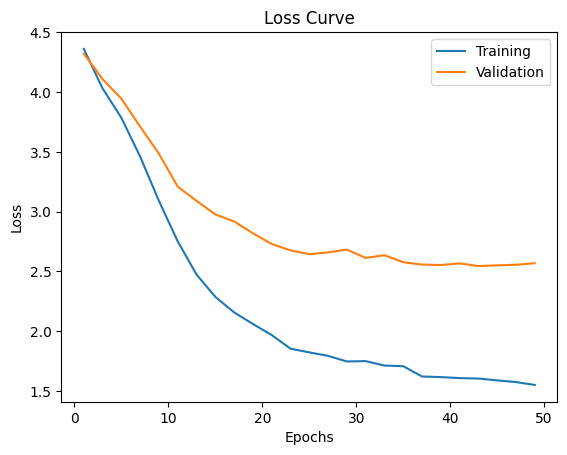

In [34]:
plot_loss_curve(train_df["Epoch"], 
                train_df["Train Loss"], 
                train_df["Val Loss"],
                title="Loss Curve")

## Architecture

### Params

In [20]:
# Hurricane w/ LoRA
from models.hurricane import HurricaneLoRAModel, LinearWithLoRA

model = HurricaneLoRAModel(rank=4, 
                           alpha=8,
                           checkpoint_path=sam_checkpoint)

# Params
total_params = sum(p.numel() for p in model.encoder.parameters())
trainable_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
print("Hurricane w/ LoRA")
print('-'*50)
print(f"Total encoder parameters: {total_params:,}")
print(f"Trainable encoder parameters: {trainable_params:,}")
print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")

# # Layers
# print('LoRA Layers in SAM: ')
# for name, module in model.named_modules():
#     if isinstance(module, LinearWithLoRA):
#         print(name)

Hurricane w/ LoRA
--------------------------------------------------
Total encoder parameters: 89,892,096
Trainable encoder parameters: 221,184
Trainable %: 0.25%


In [47]:
# Base Hurricane
model = HurricaneModel(checkpoint_path=sam_checkpoint)

# Params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Hurricane (Base)")
print('-'*50)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")

Hurricane (Base)
--------------------------------------------------
Total parameters: 91,153,637
Trainable parameters: 1,482,725
Trainable %: 1.63%


### Diagrams

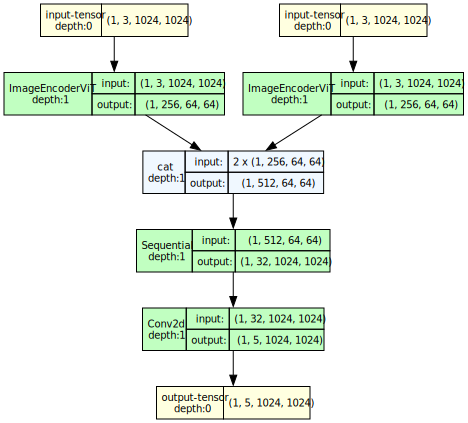

In [12]:
from torchview import draw_graph

model = HurricaneLoRAModel(checkpoint_path=sam_checkpoint)

model_input_sz = [
    (1, 3, 1024, 1024), # pre
    (1, 3, 1024, 1024)  # post
]
model_graph = draw_graph(model, input_size=model_input_sz, depth=1)

model_graph.visual_graph